# Modelo temperatura

In [1]:
function c_z(T,z) 
   c_air=331*sqrt((T+273.15-z/200)/273.15) #Modelo termodinámico v_sonido.Introduzco T_Z0 en grados centígrados por comodidad
    return c_air
end

c_z (generic function with 1 method)

# Reflexión contra el suelo caso 2D

Sabemos que el ángulo polar será más de 90 y menos de 180. Separando en dos rayos, podemos acotar el tiempo máximo para cada uno. Tomamos el suelo como pared rígida.



In [2]:
#Datos
T=23.
Source=[0.,50.]
Receiver=[700.,30.]

2-element Vector{Float64}:
 700.0
  30.0

In [3]:
function punto_corte(p1, p2)
    # Extraer las coordenadas de los puntos
    x1, y1 = p1
    x2, y2 = p2
    # Calcular la pendiente de la recta
    m = (y2 - y1) / (x2 - x1)
    # Calcular el punto de corte con el eje X (cuando y=0)
    x_corte = x1 - y1 / m
    return x_corte
end

theta_i=135 #Tomamos la media 
using DifferentialEquations
function g!(dg, g, p, t)
    q0, qx = p
    c=c_z(T,g[2])
    q_aux = sqrt(qx^2 + g[3]^2)
    dg[1] = c*qx/q_aux #Variacion coordenada X
    dg[2] = c*g[3]/q_aux #Variacion coordenada Z
    dg[3]=+q_aux*(331^2/(400*273.15))/c #Variacion qz
end
c_source=c_z(T,Source[1])
# Con la fuente y el receptor damos un ángulo inicial.
q0=1/c_source
##########
#Nos aseguramos que Delta_t sea suficiente
Delta_t1=3.
@time begin
t1=0.
t2=0.
theta_In_R=0.
for k in 1:15
    angulos_polar_salida = []
    angulos_incidente_reflejado = []
    tiempos = []
    t_r1=[]
    t_r2=[]
    thetas= range(theta_i-45/(2^(k-1)), theta_i+45/(2^(k-1)), 100); 
    ###########
    for i in 1:length(thetas)
        q0=1/c_source
        q_x=q0*sind(thetas[i])
        q_z=q0*cosd(thetas[i])
        # Definir los parámetros
        p = [q0, q_x]
        u0 = [Source[1],Source[2], q_z]
        tspan=[0,Delta_t1] #Tiempo lo suficientemente grande
        # Crear el problema ODE
        prob = ODEProblem(g!, u0, tspan, p)
        # Resolver el problema ODE
        sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:Delta_t1)
        # Comprobar si alguna solución está cerca del receptor
        for j in 1:length(sol_in.u)
                if sol_in.u[j][2] < 0
                    r_aux=sqrt((sol_in.u[j][1] - sol_in.u[j-1][1])^2 +(sol_in.u[j][2] -sol_in.u[j-1][2])^2)
                    z_aux=sol_in.u[j][2] -sol_in.u[j-1][2]
                    theta_in_r=rad2deg(acos(z_aux/r_aux)) #Cálculo ángulo incidente que para este modelo de impedacia es igual al reflejado.
                    #Ahora cálculo reflejo
                    q0=1/c_z(T,sol_in.u[j][2]) 
                    q_x=q0*sind(180-theta_in_r)  #El ángulo reflejado ya se corresponde al polar (respecto a la vertical)
                    q_z=q0*cosd(180-theta_in_r)
                    # Definir los parámetros
                    p = [q0, q_x]
                    u0 = [punto_corte([sol_in.u[j-1][1],sol_in.u[j-1][2]],[sol_in.u[j][1],sol_in.u[j][2]]),0, q_z]
                    #Cálculo tiempo suficiente
                    r_P_Receiver=sqrt((sol_in.u[j][1] - Receiver[1])^2 +(sol_in.u[j][2] -Receiver[2])^2)
                    Delta_t2=r_P_Receiver/c_z(T,100.)
                    tspan=[0,Delta_t2]
                    # Crear el problema ODE asociado a la reflexión
                    prob = ODEProblem(g!, u0, tspan, p)
                    # Resolver el problema ODE asociado a la reflexión
                    sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:Delta_t2)
                    for l in 1:length(sol_r.u)
                        if sqrt((sol_r.u[l][1] - Receiver[1])^2 +(sol_r.u[l][2] - Receiver[2])^2) < r_P_Receiver/(10*2^(k-1))
                            push!(angulos_polar_salida, thetas[i])
                            push!(angulos_incidente_reflejado, theta_in_r)
                            push!(tiempos, sol_in.t[j]+ sol_r.t[l])
                            push!(t_r1, sol_in.t[j])
                            push!(t_r2, sol_r.t[l])
                            break
                        end
                    end
                    break
                end
            end
        end
        if length(tiempos)==0
            break
        else
            traveltime_minimo = findmin(tiempos)
            println("El traveltime para la iteración ", k , " es: ", traveltime_minimo[1])
            indice = argmin(tiempos)
            theta_i=angulos_polar_salida[indice]
            println("El ángulo polar de salida para la iteración ", k , " es: ", theta_i)
            theta_In_R=angulos_incidente_reflejado[indice]
            println("El ángulo con el que incide para la iteración ", k , " es: ", theta_In_R, " y se refleja un ángulo ", 180-theta_In_R, " respecto a la vertical" )
            t1=t_r1[indice]
            t2=t_r2[indice]
            println("El tiempo del rayo incidente es: ", t1)
            println("El tiempo del rayo reflejado es: ", t2 )
        end
    end
end

El traveltime para la iteración 1 es: 1.96
El ángulo polar de salida para la iteración 1 es: 97.27272727272727
El ángulo con el que incide para la iteración 1 es: 97.08058238880226 y se refleja un ángulo 82.91941761119774 respecto a la vertical
El tiempo del rayo incidente es: 1.162
El tiempo del rayo reflejado es: 0.798
El traveltime para la iteración 2 es: 2.0060000000000002
El ángulo polar de salida para la iteración 2 es: 97.04545454545455
El ángulo con el que incide para la iteración 2 es: 96.84692445334392 y se refleja un ángulo 83.15307554665608 respecto a la vertical
El tiempo del rayo incidente es: 1.2
El tiempo del rayo reflejado es: 0.806
El traveltime para la iteración 3 es: 2.026
El ángulo polar de salida para la iteración 3 es: 96.70454545454545
El ángulo con el que incide para la iteración 3 es: 96.49543816868261 y se refleja un ángulo 83.50456183131739 respecto a la vertical
El tiempo del rayo incidente es: 1.263
El tiempo del rayo reflejado es: 0.763
El traveltime para

In [6]:
#Dibujo
using Plots
using LinearAlgebra
q0=1/c_source
q_x=q0*sind(theta_i)
q_z=q0*cosd(theta_i)
# Definir los parámetros
p = [q0, q_x]
u0 = [Source[1],Source[2], q_z]
tspan=[0,t1] #Tiempo lo suficientemente grande
# Crear el problema ODE
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE
sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t1)
x_data_in = [u[1] for u in sol_in.u]
z_data_in = [u[2] for u in sol_in.u]
q=plot()
plot!(x_data_in, z_data_in, xlabel="x (m)", ylabel="z (m)", label="Incident acoustic ray \$\\tau_1 = $t1\$ s", color=:red)
#####
q0=1/c_z(T,sol_in.u[end][2])
q_x=q0*sind(180- theta_In_R)  #El ángulo reflejado ya se corresponde al polar (respecto a la vertical)
q_z=q0*cosd(180- theta_In_R)
# Definir los parámetros
p = [q0, q_x]
u0 = [punto_corte([sol_in.u[end-1][1],sol_in.u[end-1][2]],[sol_in.u[end][1],sol_in.u[end][2]]),0, q_z]
#Cálculo tiempo suficiente
r_P_Receiver=sqrt((sol_in.u[end][1] - Receiver[1])^2 +(sol_in.u[end][2] -Receiver[2])^2)
Delta_t2=r_P_Receiver/c_z(T,Receiver[2])
tspan=[0, t2]
# Crear el problema ODE asociado a la reflexión
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE asociado a la reflexión
sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001: t2)
x_data_r = [u[1] for u in sol_r.u]
z_data_r = [u[2] for u in sol_r.u]
Error_relativo=(sqrt((sol_r.u[end][2]-Receiver[2])^2+(sol_r.u[end][1]-Receiver[1])^2)/norm(Receiver-Source))*100  #Tengo que ver como se calcula
println("Error relativo: ",Error_relativo, " %")
plot!(x_data_r, z_data_r, xlabel="x (m)", ylabel="z (m)",label="Reflected acoustic ray \$\\tau_2 = $t2\$ s", color=:blue)
plot!(0:100:1000, zeros(11),  color=:black, label="Ground") #Eje X
scatter!([Source[1]], [Source[2]], color=:red, label="Source")
scatter!([Receiver[1]], [Receiver[2]], color=:blue, label="Receiver")
savefig(q,"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion2DPlano.png")
#xlims!(430,450)
#ylims!(-0.03,0.05)

Error relativo: 0.0022656031347109166 %


"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion2DPlano.png"

Tenemos un error del tiempo del rayo incidente aproximadamente del tiempo que le lleva recorrer 2 cm. Aproximadamente 6e-05s. 

# Terreno variable Caso 2D
Introducimos un valle. Esto provocará que la altitud del suelo con respecto al mar sea una función del terreno g(x).

Medimos el traveltime para una reflexión contra el terreno variable en el caso homogéneo de velocidad del sonido. Tomamos el terreno como una pared rígida ($Z \Rightarrow \infty$), por lo que el ángulo de salida será igual al de entrada. 

In [4]:
using Plots
# Definición de una función de terreno que simule un valle. Escogemos una forma gaussiana
function g_plano(x)
    return 1000*exp(-(((x-1001)/(1001))^2 ))
end


# Creación de la malla de puntos (x,y)
x = range(1, stop=2001, length=1000)

# Cálculo de la altitud z en cada punto (x,y)
h_i = [g_plano(xi) for xi in x]
# Visualización del terreno
p=plot()
plot!(x, h_i, xlabel="x (m)", ylabel="Altitude of the terrain relative to sea level (m)", legend=false)
savefig(p,"C:\\Users\\Miguel\\Desktop\\TFM\\TerrenoVariable2D.png")

"C:\\Users\\Miguel\\Desktop\\TFM\\TerrenoVariable2D.png"

Suponemos receptor a más altura que emisor. Sabemos que la altura a la cuál rebota el rayo no puede ser mayor que la del receptor. Veamos a que X corresponde esa altura,  aunque  sin embargo, la función no es biyectiva, por lo que no tiene una función inversa única en todo su dominio. Nos quedamos lógicamente con los valores de x a la izquierda del máximo.

Nos quedamos con todos los rayos emitidos que pasen por el interior del dominio del terreno, a una altura menor que la del receptor. Nos quedamos posteriormente con los puntos exterior e interno más próximos a la frontera, de cada rayo, y analizamos a que ángulo reflexiona.  


Definimos una normal al terreno en el punto de incidencia, denominémosle $P=(P_1,P_2)$, y vemos el ángulo de incidencia desde el punto exterior más cercano(aproximando por recta, con pendiente $m_1=\dfrac{P_2-x_2}{P_1-x_1}$) . Este ángulo incidente coincidirá con el reflejado.

Siendo $P_2=f(P_1)$, la ecuación que define a la recta normal en un punto P de la curva que corresponde al terreno es:
$y - f(P_1) = \dfrac{-1}{f'(P_1)}(x - P_1)$. Su pendiente es $m_2=\dfrac{-1}{f'(P_1)}$.

El ángulo que forman dos rectas es: $tg(\alpha)=\dfrac{|m_2 - m_1|} {1 + m_1m_2}$. El ángulo de incidencia y, por tanto, el reflejado será $\alpha$.

Revisar: El ángulo que forma la recta correspondiente a la normal y el eje vertical es $\alpha_2=90º-arctg(m_2)$.

In [12]:
function dg_plano(x)
    return -2*1000*(x-1001)/(1001^2)*exp(-(((x-1001)/(1001))^2 ))
end
function angulo_incidente(g_plano,dg_plano, P1, P_ext)
    m1=(g_plano(P1)-P_ext[2])/(P1-P_ext[1])
    if dg_plano(P1)==0
       alpha=90- rad2deg(atan(m1))
    else
        m2=-1/dg_plano(P1)
        alpha= rad2deg(atan(abs(m2 - m1) / (1 + m1*m2)))
    end
    return alpha
end

angulo_incidente (generic function with 1 method)

In [13]:
#Datos
T= 23.
Source=[0.,500.]
Receiver=[0.,700.]


2-element Vector{Float64}:
   0.0
 700.0

In [14]:
using Roots
function punto_corte_funcion(p1, p2, f)
    # Extraer las coordenadas de los puntos
    x1, y1 = p1
    x2, y2 = p2
    # Calcular la pendiente de la recta
    m = (y2 - y1) / (x2 - x1)
    # Definir la recta
    recta(x) = m * (x - x1) + y1
    # Definir la ecuación a resolver
    ecuacion(x) = recta(x) - f(x)
    # Usar el método de Newton para encontrar la raíz
    x_corte = find_zero(ecuacion, (x1+x2)/2)
    return (x_corte, f(x_corte))
end

theta_i=135.
using DifferentialEquations
function g!(dg, g, p, t)
    q0, qx = p
    c=c_z(T,g[2])
    q_aux = sqrt(qx^2 + g[3]^2)
    dg[1] = c*qx/q_aux #Variacion coordenada X
    dg[2] = c*g[3]/q_aux #Variacion coordenada Z
    dg[3]=+q_aux*(331^2/(400*273.15))/c #Variacion qz
end
c_source=c_z(T,Source[1])
# Con la fuente y el receptor damos un ángulo inicial.
q0=1/c_source
##########
#Nos aseguramos que Delta_t sea suficiente
Delta_t1=5.
@time begin
t1=0.
t2=0.
theta_R=0.
for k in 1:15
    angulos_polar_salida = []
    theta_reflejado = []
    tiempos = []
    t_r1=[]
    t_r2=[]
    thetas= range(theta_i-45/(2^(k-1)), theta_i+45/(2^(k-1)), 500); 
    ###########
    for i in 1:length(thetas)
        q0=1/c_source
        q_x=q0*sind(thetas[i])
        q_z=q0*cosd(thetas[i])
        # Definir los parámetros
        p = [q0, q_x]
        u0 = [Source[1],Source[2], q_z]
        tspan=[0,Delta_t1] #Tiempo lo suficientemente grande
        # Crear el problema ODE
        prob = ODEProblem(g!, u0, tspan, p)
        # Resolver el problema ODE
        sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:Delta_t1)
        # Comprobar si alguna solución está cerca del receptor
        for j in 1:length(sol_in.u)
            if sol_in.u[j][2]-g_plano(sol_in.u[j][1]) < 0  && j>1
                p_ext=[sol_in.u[j-1][1],sol_in.u[j-1][2]]
                p_in=[sol_in.u[j][1],sol_in.u[j][2]]
                x_P, y_P= punto_corte_funcion(p_ext, p_in, g_plano)  
                alpha_in_r=angulo_incidente(g_plano,dg_plano, x_P, p_ext)
                q0=1/c_z(T,g_plano(x_P))
                if x_P<=1001 #Izquierda vertical
                    alpha_N_V=rad2deg(atan(1/(dg_plano(x_P))))-90 #Ángulo que forma la normal al terreno y la vertical
                else
                    alpha_N_V=90+rad2deg(atan(-1/(dg_plano(x_P))))  
                end
                q_x=q0*sind(alpha_N_V+alpha_in_r)  #El ángulo reflejado ya se corresponde al polar (respecto a la vertical)
                q_z=q0*cosd(alpha_N_V+alpha_in_r)
                # Definir los parámetros
                p = [q0, q_x]
                u0 = [x_P,y_P, q_z]
                #Cálculo tiempo suficiente
                r_P_Receiver=sqrt((x_P - Receiver[1])^2 +(g_plano(x_P) -Receiver[2])^2)
                Delta_t2=r_P_Receiver/c_z(T,Receiver[2])
                tspan=[0,Delta_t2]
                # Crear el problema ODE asociado a la reflexión
                prob = ODEProblem(g!, u0, tspan, p)
                # Resolver el problema ODE asociado a la reflexión
                sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:Delta_t2)
                for l in 1:length(sol_r.u)
                    if sqrt((sol_r.u[l][1] - Receiver[1])^2 +(sol_r.u[l][2] - Receiver[2])^2) < r_P_Receiver/(20*2^(k-1))
                        push!(angulos_polar_salida, thetas[i])
                        push!(theta_reflejado, alpha_N_V+alpha_in_r)
                        push!(tiempos, sol_in.t[j]+ sol_r.t[l])
                        push!(t_r1, sol_in.t[j])
                        push!(t_r2, sol_r.t[l])
                        break
                    end
                end
                break #Solo nos interesa el primer iterante j que pasa por el terreno variable
            end
        end
    end
    if length(tiempos)==0
        break
    else
        traveltime_minimo = findmin(tiempos)
        println("El traveltime para la iteración ", k , " es: ", traveltime_minimo[1])
        indice = argmin(tiempos)
        theta_i=angulos_polar_salida[indice]
        println("El ángulo polar de salida para la iteración ", k , " es: ", theta_i)
        theta_R=theta_reflejado[indice]
        println("Se refleja un ángulo polar de ", theta_R, " º" )
        t1=t_r1[indice]
        println("El tiempo del rayo incidente es: ", t1)
        t2=t_r2[indice]
        println("El tiempo del rayo reflejado es: ", t2 )
    end
end
end
                              

El traveltime para la iteración 1 es: 1.091
El ángulo polar de salida para la iteración 1 es: 122.64529058116233
Se refleja un ángulo polar de -19.673099392325888 º
El tiempo del rayo incidente es: 0.325
El tiempo del rayo reflejado es: 0.766

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\Miguel\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606



El traveltime para la iteración 2 es: 1.112
El ángulo polar de salida para la iteración 2 es: 122.6002004008016
Se refleja un ángulo polar de -19.630855121950297 º
El tiempo del rayo incidente es: 0.325
El tiempo del rayo reflejado es: 0.787
El traveltime para la iteración 3 es: 1.122
El ángulo polar de salida para la iteración 3 es: 122.57765531062124
Se refleja un ángulo polar de -19.60973320433926 º
El tiempo del rayo incidente es: 0.325
El tiempo del rayo reflejado es: 0.797
El traveltime para la iteración 4 es: 1.127
El ángulo polar de salida para la iteración 4 es: 122.65656312625251
Se refleja un ángulo polar de -19.683660550308925 º
El tiempo del rayo incidente es: 0.325
El tiempo del rayo reflejado es: 0.802
El traveltime para la iteración 5 es: 1.129
El ángulo polar de salida para la iteración 5 es: 122.76365230460922
Se refleja un ángulo polar de -19.783993342685445 º
El tiempo del rayo incidente es: 0.325
El tiempo del rayo reflejado es: 0.804
El traveltime para la iteraci

In [17]:
#Dibujo
using Plots
using LinearAlgebra
q0=1/c_source
q_x=q0*sind(theta_i)
q_z=q0*cosd(theta_i)
# Definir los parámetros
p = [q0, q_x]
u0 = [Source[1],Source[2], q_z]
tspan=[0,t1] #Tiempo lo suficientemente grande
# Crear el problema ODE
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE
sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t1)
x_data_in = [u[1] for u in sol_in.u]
z_data_in = [u[2] for u in sol_in.u]
q=plot()
plot!(x_data_in, z_data_in, xlabel="x (m)", ylabel="z (m)", label="Incident acoustic ray \$\\tau_1 = $t1\$ s", color=:red)
#####
q0=1/c_z(T,sol_in.u[end][2])
q_x=q0*sind(theta_R)  #El ángulo reflejado ya se corresponde al polar (respecto a la vertical)
q_z=q0*cosd(theta_R)
# Definir los parámetros
p = [q0, q_x]

p_ext=[sol_in.u[end-1][1],sol_in.u[end-1][2]]
p_in=[sol_in.u[end][1],sol_in.u[end][2]]
x_P, y_P= punto_corte_funcion(p_ext, p_in, g_plano)

u0 = [x_P,y_P, q_z]
#Cálculo tiempo suficiente
r_P_Receiver=sqrt((sol_in.u[end][1] - Receiver[1])^2 +(sol_in.u[end][2] -Receiver[2])^2)
Delta_t2=r_P_Receiver/c_z(T,Receiver[2])
tspan=[0, t2]
# Crear el problema ODE asociado a la reflexión
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE asociado a la reflexión
sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001: t2)
x_data_r = [u[1] for u in sol_r.u]
z_data_r = [u[2] for u in sol_r.u]
Error_relativo=(sqrt((sol_r.u[end][2]-Receiver[2])^2+(sol_r.u[end][1]-Receiver[1])^2)/norm(r_P_Receiver))*100  #Tengo que ver como se calcula
println("Error_relativo: ",Error_relativo, " %")
println("Tiempo computacional método: 1.817197 s")
plot!(x_data_r, z_data_r, xlabel="x (m)", ylabel="z (m)", label="Reflected acoustic ray \$\\tau_2 = $t2\$ s", color=:blue)
plot!(x, h_i, label="Variable terrain", color=:green, aspect_ratio=1)
###### Recta normal al terreno
x_P=(sol_in.u[end-1][1]+sol_in.u[end][1])/2
function recta_n(g_plano,dg_plano,x,x_P)
    y = g_plano(x_P)-1*(x - x_P)/dg_plano(x_P)
    return y
end
x_rn=0:1:700
y_rn=zeros(701)
y_rn .= recta_n.(g_plano,dg_plano,x_rn,x_P)
plot!(x_rn, y_rn, label="Normal line to the variable terrain", color=:green, style=:dash, legend=:topleft)
######
scatter!([Source[1]], [Source[2]], color=:red, label="Source")
scatter!([Receiver[1]], [Receiver[2]], color=:blue, label="Receiver")
ylims!(400,1200)
xlims!(-10,1000)
#savefig(q,"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion2DVariable.png")
#ylims!(439.5,440)
#xlims!(93,94)

Error_relativo: 0.07771529452207233 %
Tiempo computacional método: 1.817197 s


"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion2DVariable.png"

Tenemos un error del tiempo del rayo incidente aproximadamente del tiempo que le lleva recorrer 30 cm. Aproximadamente 9e-04s. 

# Caso 3D y viento

Una reflexión contra suelo plano es independiente del angulo azimutal , ya que la variación en la coordenada Z solo depende del ángulo polar. Por tanto, es equivalente al caso 2D.

Veamos contra un terreno variable.

In [3]:
using Plots
# Definición de una función de terreno que simule un valle. Escogemos una forma gaussiana
function g(x,y)
    return 1000*exp(-((x-1001)/(1001))^2-((y-1001)/(1001))^2 )
end
#Cálculo parciales
function dgx(x,y)
    return -2*((x-1001)/(1001^2))*1000*exp(-((x-1001)/(1001))^2-((y-1001)/(1001))^2 )
end
function dgy(x,y)
    return -2*((y-1001)/(1001^2))*1000*exp(-((x-1001)/(1001))^2-((y-1001)/(1001))^2 )
end


# Creación de la malla de puntos (x,y)
x = range(1, stop=2001, length=1000)
y = range(1, stop=2001, length=1000)

# Cálculo de la altitud z en cada punto (x,y)
h_i = [g(xi,yi) for xi in x , yi in y]
# Visualización del terreno
p=plot()
surface!(x, y, h_i, xlabel="x (m)", ylabel="y (m)", zlabel="Altitude of the terrain relative to sea level (m)", legend=false)
savefig(p,"C:\\Users\\Miguel\\Desktop\\TFM\\TerrenoVariable3D.png")

"C:\\Users\\Miguel\\Desktop\\TFM\\TerrenoVariable3D.png"

In [94]:
dgx(300,300)

0.5246947822811174

In [95]:
#Datos
T= 23.
Source=[0.,110.,250.]
Receiver=[50.,150.,350.]
v_wind=[2.,2.,0.]

3-element Vector{Float64}:
 2.0
 2.0
 0.0

In [96]:
using LinearAlgebra
function phi(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, v_wind::Array{Float64, 1}, tau) 
        #tgphi= (Point2[2]-Point1[2]- v_wind[2]*tau)/(Point2[1]-Point1[1]- v_wind[1]*tau) #Cálculo phi primera iteración
        #phi=rad2deg(atan(tgphi))
        phi=rad2deg(atan((Point2[2]-Point1[2]- v_wind[2]*tau),(Point2[1]-Point1[1]- v_wind[1]*tau)))
        return phi
end
using NLsolve
function punto_corte_3D(p1, p2)
    function sistema!(F, x)
    # Obtener coordenadas puntos
    F[1] = (x[2] - p1[2]) * (p2[3] - p1[3]) - (x[3] - p1[3]) * (p2[2] - p1[2]) #Plano 1
    F[2] = (x[1] - p1[1]) * (p2[3] - p1[3]) - (x[3] - p1[3]) * (p2[1] - p1[1]) #Plano 2
    F[3] = x[3]-1000*exp(-((x[1]-1001)/(1001))^2-((x[2]-1001)/(1001))^2 ) #Terreno
    end
    # Newton para encontrar interseccion
    resultado = nlsolve(sistema!, [(p1[1]+p2[1])/2, (p1[2]+p2[2])/2, (p1[3]+p2[3])/2])
    return resultado.zero[1],resultado.zero[2],resultado.zero[3]
end
function angulo(V1,V2)
    if length(V1) == 3 && length(V2) == 3
     cos_alpha = dot(V1, V2) / (norm(V1) * norm(V2))
     alpha = rad2deg(acos(cos_alpha))
    else
        error("Ambos vectores deben ser tridimensionales.")
    end
    return alpha
end

function g!(dg, g, p, t)
    qx,qy = p
    q_aux = sqrt(qx^2 + qy^2 + g[4]^2)
    c=c_z(T,g[3])
    dg[1] = c*qx/q_aux + v_wind[1] #Variación coordenada X
    dg[2] = c*qy/q_aux + v_wind[2]  #Variación coordenada Y
    dg[3] = c*g[4]/q_aux + v_wind[3] #Variación coordenada Z
    dg[4]=+q_aux*(331^2/(400*273.15))/c #Variación qz
end
#### Necesitamos una velocidad inicial, correspondiente a la fuente, y un ángulo azimutal para empezar a iterar.
c_source=c_z(T, Source[3])
####
R=norm(Receiver-Source)
t_min=R/c_z(T,min(Source[3],Receiver[3]))
t_max=R/c_z(T, max(Source[3],Receiver[3]))
phi1=phi(Source,Receiver,v_wind, t_max) #Acotación teórica phi
phi2=phi(Source,Receiver,v_wind, t_min) #Acotación teórica phi
phi_i=(phi1+phi2)/2 #La media de la cota de phi como phi para la primera iteración
#######
theta_i=135.
@time begin
t1=0.
t2=0.
theta_R=0.
    
    
for l in 1:10
    angulos_theta = []
    angulos_phi = []
    theta_reflejado = []
    tiempos = []
    t_r1=[]
    t_r2=[]
    thetas= range(theta_i-45/(2^(l-1)), theta_i+45/(2^(l-1)), 50); #Barrido theta. Se podría acotar más, teóricamente o con datos (ML u otras técnicas)
    if l==1
        phis=(min(phi1,phi2):0.05:max(phi1,phi2)) 
    else
        phi_distance=max(phi1,phi2)-min(phi1,phi2)
        phis= range(phi_i-phi_distance/(2^(l)), theta_i-phi_distance/(2^(l)), 20);
    end
    ###########
    for i in 1:length(thetas)
        for j in 1:length(phis)
            q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
            q_x=q0*cosd(phis[j])*sind(thetas[i])
            q_y=q0*sind(phis[j])*sind(thetas[i])
            q_z=q0*cosd(thetas[i])
            # Definir los parámetros
            p = [q_x, q_y]
            u0 = [Source[1],Source[2],Source[3], q_z]
            tspan=[0,t_max] #Tiempo lo suficientemente grande
            # Crear el problema ODE
            prob = ODEProblem(g!, u0, tspan, p)
            # Resolver el problema ODE
            sol_in = solve(prob, RK4(), dt=1e-3, saveat=0:0.001:t_max)
            # Comprobar si alguna solución está cerca del receptor
            for k in 1:length(sol_in.u)
                if sol_in.u[k][3]-g(sol_in.u[k][1],sol_in.u[k][2]) < 0  && k>1
                    p_ext=[sol_in.u[k-1][1],sol_in.u[k-1][2],sol_in.u[k-1][3]]
                    p_in=[sol_in.u[k][1],sol_in.u[k][2],sol_in.u[k][3]]
                    x_P, y_P, z_P= punto_corte_3D(p_ext, p_in)  
                 #Duda: Como cambia tener 2 ángulos que inciden
                    #Calculamos ángulo incidente como el que forman los vectores del rayo incidente y el del normal al plano
                    V_in=p_ext-[x_P,y_P,z_P]
                    V_normal=[-dgx(x_P,y_P),-dgy(x_P,y_P),1] #Vector normal exterior , no normalizado
                    alpha_in_r=angulo(V_in,V_normal)
                    q0=1/c_z(T,g(x_P,y_P)) #Punto de reflexion, no hay viento por ser suelo
                    ang_nor_ver= 360-angulo(V_normal,[0.,0.,1.])   #Angulo que forma la normal con la vertical
                    q_x=q0*cosd(phis[j])*sind(ang_nor_ver+alpha_in_r)  
                    q_y=q0*cosd(phis[j])*sind(ang_nor_ver+alpha_in_r)
                    q_z=q0*cosd(ang_nor_ver+alpha_in_r)
                    # Definir los parámetros
                    p = [q_x, q_y]
                    u0 = [x_P, y_P, z_P, q_z]
                    #Cálculo tiempo suficiente
                    r_P_Receiver=sqrt((x_P - Receiver[1])^2 +(y_P -Receiver[2])^2+(z_P -Receiver[3])^2)
                    Delta_t2=r_P_Receiver/c_z(T,max(Source[3],Receiver[3]))
                    tspan=[0,Delta_t2]
                    # Crear el problema ODE asociado a la reflexión
                    prob = ODEProblem(g!, u0, tspan, p)
                    # Resolver el problema ODE asociado a la reflexión
                    sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:Delta_t2)
                    for m in 1:length(sol_r.u)
                        if sqrt((sol_r.u[m][1] - Receiver[1])^2 +(sol_r.u[m][2] - Receiver[2])^2 +(sol_r.u[m][3] - Receiver[3])^2)< r_P_Receiver/(20*2^(l-1))
                            push!(angulos_theta, thetas[i])
                            push!(angulos_phi, phis[j])
                            push!(theta_reflejado, ang_nor_ver+alpha_in_r)
                            push!(tiempos, sol_in.t[k]+ sol_r.t[m])
                            push!(t_r1, sol_in.t[k])
                            push!(t_r2, sol_r.t[m])
                            #break
                        end
                    end
                    break #Solo nos interesa el primer iterante k que pasa por el terreno variable
                end
            end
        end
        end
        if length(tiempos)==0
            break
        else
            traveltime_minimo = findmin(tiempos)
            println("El traveltime para la iteración ", l , " es: ", traveltime_minimo[1])
            indice = argmin(tiempos)
            theta_i=angulos_theta[indice]
            println("El ángulo polar de salida para la iteración ", l , " es: ", theta_i)
            theta_R=theta_reflejado[indice]
            println("Se refleja un ángulo polar de ", theta_R, " º" )
            t1=t_r1[indice]
            println("El tiempo del rayo incidente es: ", t1)
            t2=t_r2[indice]
            println("El tiempo del rayo reflejado es: ", t2 )
            phi_i=angulos_phi[indice]
        end
    end
end

                    

El traveltime para la iteración 1 es: 0.665
El ángulo polar de salida para la iteración 1 es: 128.57142857142858
Se refleja un ángulo polar de 358.3998611492805 º
El tiempo del rayo incidente es: 0.244
El tiempo del rayo reflejado es: 0.421
El traveltime para la iteración 2 es: 0.6759999999999999
El ángulo polar de salida para la iteración 2 es: 128.1122448979592
Se refleja un ángulo polar de 358.8022905605617 º
El tiempo del rayo incidente es: 0.245
El tiempo del rayo reflejado es: 0.431
El traveltime para la iteración 3 es: 0.681
El ángulo polar de salida para la iteración 3 es: 128.34183673469389
Se refleja un ángulo polar de 358.6010571170283 º
El tiempo del rayo incidente es: 0.244
El tiempo del rayo reflejado es: 0.437
El traveltime para la iteración 4 es: 0.6839999999999999
El ángulo polar de salida para la iteración 4 es: 128.22704081632654
Se refleja un ángulo polar de 358.70162080130206 º
El tiempo del rayo incidente es: 0.244
El tiempo del rayo reflejado es: 0.44
El travelti

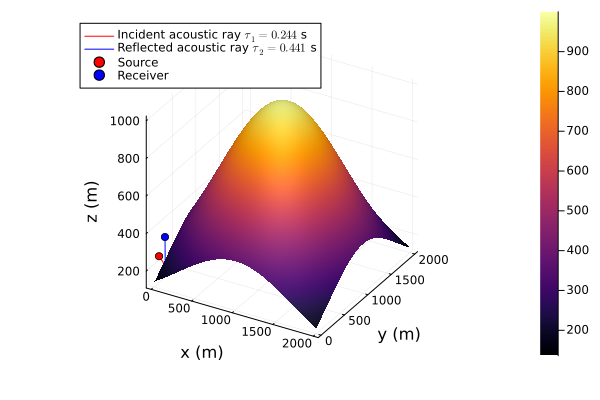

In [106]:
#Dibujo
using Plots
using LinearAlgebra
p=plot()
q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
q_x=q0*cosd(phi_i)*sind(theta_i)
q_y=q0*sind(phi_i)*sind(theta_i)
q_z=q0*cosd(theta_i)
# Definir los parámetros
p = [q_x, q_y]
u0 = [Source[1],Source[2],Source[3], q_z]
tspan=[0,t1] #Tiempo lo suficientemente grande
# Crear el problema ODE
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE
sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t1)
x_data_in = [u[1] for u in sol_in.u]
y_data_in = [u[2] for u in sol_in.u]
z_data_in = [u[3] for u in sol_in.u]
q=plot()
plot!(x_data_in, y_data_in, z_data_in, xlabel="x (m)", ylabel="y (m)",zlabel="z (m)", label="Incident acoustic ray \$\\tau_1 = $t1\$ s", color=:red)
#####
p_ext=[sol_in.u[end-1][1],sol_in.u[end-1][2],sol_in.u[end-1][3]]
p_in=[sol_in.u[end][1],sol_in.u[end][2],sol_in.u[end][3]]
x_P, y_P, z_P= punto_corte_3D(p_ext, p_in)  
q0=1/c_z(T,g(x_P,y_P)) #Punto de reflexion, no hay viento por ser suelo
q_x=q0*cosd(phi_i)*sind(theta_R)  
q_y=q0*cosd(phi_i)*sind(theta_R)
q_z=q0*cosd(theta_R)
# Definir los parámetros
p = [q_x, q_y]
u0 = [x_P, y_P, z_P, q_z]
tspan=[0,t2]
# Crear el problema ODE asociado a la reflexión
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE asociado a la reflexión
sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t2)
x_data_r = [u[1] for u in sol_r.u]
y_data_r = [u[2] for u in sol_r.u]
z_data_r = [u[3] for u in sol_r.u]
plot!(x_data_r, y_data_r, z_data_r, xlabel="x (m)", ylabel="y (m)",zlabel="z (m)", label="Reflected acoustic ray \$\\tau_2 = $t2\$ s", color=:blue)

# Creación de la malla de puntos (x,y)
x = range(1, stop=2001, length=1000)
y = range(1, stop=2001, length=1000)
# Cálculo de la altitud z en cada punto (x,y)
h_i = [g(xi,yi) for xi in x , yi in y]
# Visualización del terreno
surface!(x, y, h_i, xlabel="x (m)", ylabel="y (m)", zlabel="z (m)")
# Ajustes de visualización
plot!(legend=:topleft, alpha=0.5) # Añade transparencia al terreno
scatter!([Source[1]], [Source[2]], [Source[3]], label="Source", color=:red) # Punto de inicio
scatter!([Receiver[1]], [Receiver[2]], [Receiver[3]], label="Receiver", color=:blue) # Punto de fin
#savefig(q,"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion3DVariable.png")

In [105]:
#Dibujo
using Plots
using LinearAlgebra
q=plot()
q0=1/(c_source + (v_wind[1]*cosd(phi_i)+ v_wind[2]*sind(phi_i))*cosd(theta_i) )
q_x=q0*cosd(phi_i)*sind(theta_i)
q_y=q0*sind(phi_i)*sind(theta_i)
q_z=q0*cosd(theta_i)
# Definir los parámetros
p = [q_x, q_y]
u0 = [Source[1],Source[2],Source[3], q_z]
tspan=[0,t1] #Tiempo lo suficientemente grande
# Crear el problema ODE
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE
sol_in = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t1)
x_data_in = [u[1] for u in sol_in.u]
y_data_in = [u[2] for u in sol_in.u]
z_data_in = [u[3] for u in sol_in.u]
t1_r=round(t1,digits=3)
plot!(x_data_in, y_data_in, z_data_in, xlabel="x (m)", ylabel="y (m)",zlabel="z (m)", label="Incident acoustic ray \$\\tau_1 = $t1_r\$ s", color=:red)
#####
p_ext=[sol_in.u[end-1][1],sol_in.u[end-1][2],sol_in.u[end-1][3]]
p_in=[sol_in.u[end][1],sol_in.u[end][2],sol_in.u[end][3]]
x_P, y_P, z_P= punto_corte_3D(p_ext, p_in)  
q0=1/c_z(T,g(x_P,y_P)) #Punto de reflexion, no hay viento por ser suelo
q_x=q0*cosd(phi_i)*sind(theta_R)  
q_y=q0*cosd(phi_i)*sind(theta_R)
q_z=q0*cosd(theta_R)
# Definir los parámetros
p = [q_x, q_y]
u0 = [x_P, y_P, z_P, q_z]
tspan=[0,t2]
# Crear el problema ODE asociado a la reflexión
prob = ODEProblem(g!, u0, tspan, p)
# Resolver el problema ODE asociado a la reflexión
sol_r = solve(prob, RK4(), dt=1e-4, saveat=0:0.001:t2)
x_data_r = [u[1] for u in sol_r.u]
y_data_r = [u[2] for u in sol_r.u]
z_data_r = [u[3] for u in sol_r.u]
plot!(x_data_r, y_data_r, z_data_r, xlabel="x (m)", ylabel="y (m)",zlabel="z (m)", label="Reflected acoustic ray \$\\tau_2 = $t2\$ s", color=:blue)


# Ajustes de visualización
plot!(legend=:topleft, alpha=0.5) # Añade transparencia al terreno
scatter!([Source[1]], [Source[2]], [Source[3]], label="Source", color=:red) # Punto de inicio
scatter!([Receiver[1]], [Receiver[2]], [Receiver[3]], label="Receiver", color=:blue) # Punto de fin

# Creación de la malla de puntos (x,y)
x = range(1, stop=x_P, length=1000)
y = range(1, stop=y_P, length=1000)
# Cálculo de la altitud z en cada punto (x,y)
h_i = [g(xi,yi) for xi in x , yi in y]
# Visualización del terreno
surface!(x, y, h_i, xlabel="x (m)", ylabel="y (m)", zlabel="z (m)")
#savefig(q,"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion3DVariableAmpliado.png")

"C:\\Users\\Miguel\\Desktop\\TFM\\Reflexion3DVariableAmpliado.png"